<a href="https://colab.research.google.com/github/HagarIbrahiem/Generative-Models/blob/main/Generative_Models_%7C%20Variational_Autoencoders_%7C_Anime_Faces_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook implement a Variational Autoencoder (VAE) using the anime faces dataset by MckInsey666.

## Libs

In [38]:
# Install packages for compatibility with the autograder
!pip install tensorflow==2.8.0 --quiet
!pip install keras==2.8.0 --quiet

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

## Parameters

In [40]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

## Load Data

In [41]:
# make the data directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/learning-datasets/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()



## Prepare Dataset

In [42]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [43]:
# get the list containing the image paths
paths = get_dataset_slice_paths("/tmp/anime/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display images

In [44]:
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


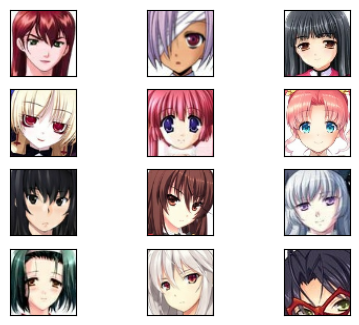

In [45]:
display_faces(validation_dataset, size=12)

### Sampling Class

Create the custom layer to provide:
-  the Gaussian noise input
- along with the mean (mu) and
-  standard deviation (sigma) of **the encoder's output**.

Recall the equation to combine these:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [46]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    mu, sigma =inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    return  z

### Encoder Layers

Next,we use the Functional API to stack the encoder layers and output mu, sigma and the shape of the features before flattening.

We also use 1024 units in the Dense layer before we get mu and sigma

In [47]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv3")(x)



  batch_3 = tf.keras.layers.BatchNormalization()(x)
  print(batch_3.shape)


  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)

  x = tf.keras.layers.Dense(1024, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)


  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_3.shape



### Encoder Model

We feed the output from the above function to the Sampling layer we defined earlier. That will have the latent representations that can be fed to the decoder network later.


In [49]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  inputs =tf.keras.layers.Input(shape=input_shape)

  mu, sigma, conv_shape =  encoder_layers(inputs, latent_dim=LATENT_DIM)
  z = Sampling()((mu, sigma))
  model =  tf.keras.Model(inputs, outputs=[mu, sigma, z])
  model.summary()
  return model, conv_shape

### Decoder Layers
Next, we will define the decoder layers. This will expand the latent representations back to the original image dimensions. After training  VAE model, we can use this decoder model to generate new data by feeding random inputs.

In [50]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  ### START CODE HERE ###
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions

  x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_4")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  return x


### Decoder Model

In [51]:

def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  model.summary()
  return model

### Kullback–Leibler Divergence
Next, the function below used to compute the Kullback–Leibler Divergence loss. This will be used to improve the generative capability of the model.

In [52]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together


 define the whole VAE model. we use model.add_loss() to add the KL reconstruction loss. This will be accessed and added to the loss later in the training loop.

In [53]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the decoder
  reconstructed = decoder(z)

  # define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

Next, we define a helper function to return the encoder, decoder, and vae models just defined.

In [55]:

def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [56]:

encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

(None, 8, 8, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encode_conv1 (Conv2D)          (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['encode_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 encode_conv2 (Conv2D)          (None, 16, 16, 64)   18496       ['batch_nor

## Train the Model
We configure the model for training. We defined some losses, the optimizer, and the loss metric

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

Generate 16 images in a 4x4 grid to show progress of image generation. We've defined a utility function for that below.

In [58]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()


**The general steps are:**

1- feed a training batch to the VAE model

2- compute the reconstruction loss (hint: use the mse_loss defined above
instead of bce_loss in the ungraded lab, then multiply by the flattened dimensions of the image (i.e. 64 x 64 x 3)

3- add the KLD regularization loss to the total loss (you can access the losses property of the vae model)

4- get the gradients

5- use the optimizer to update the weights



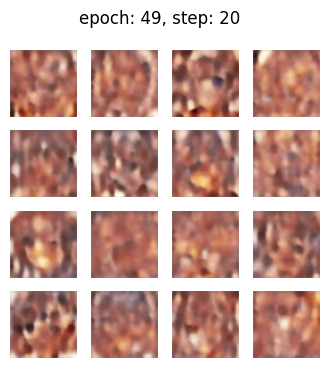

Epoch: 49 step: 20 mean loss = 356.9362
Epoch: 49 step: 21 mean loss = 356.81927
Epoch: 49 step: 22 mean loss = 356.70602
Epoch: 49 step: 23 mean loss = 356.59174
Epoch: 49 step: 24 mean loss = 356.4736
Epoch: 49 step: 25 mean loss = 356.35648


In [59]:
# Training loop. Display generated images each epoch

epochs = 50

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      ### START CODE HERE ###
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 12288

      # add KLD regularization loss
      loss += sum(vae.losses)
      # Compute reconstruction loss

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))


## Plot Reconstructed Images

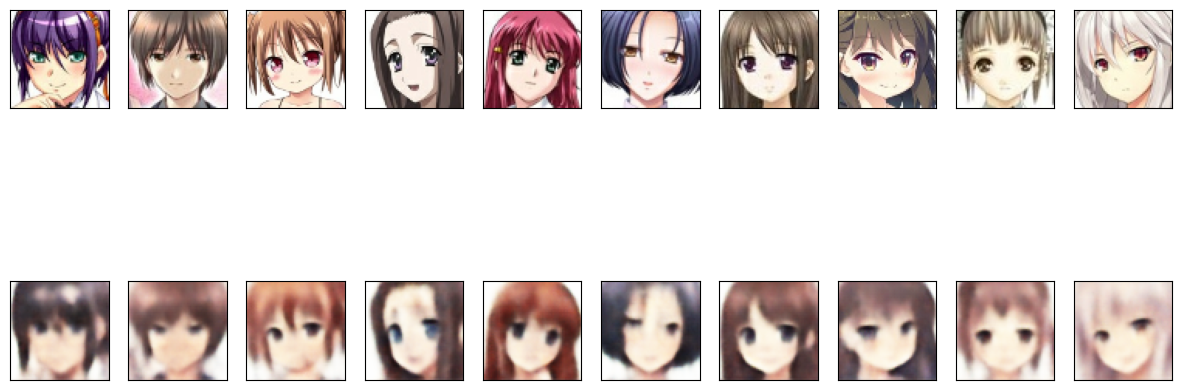

In [61]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

## Plot Generated Images

Using the default parameters, it can take a long time to train the model well enough to generate good fake anime faces. In case you decide to experiment, we use the code block below to display an 8x8 gallery of fake data generated from the  model. Here is a sample gallery generated after 50 epochs.

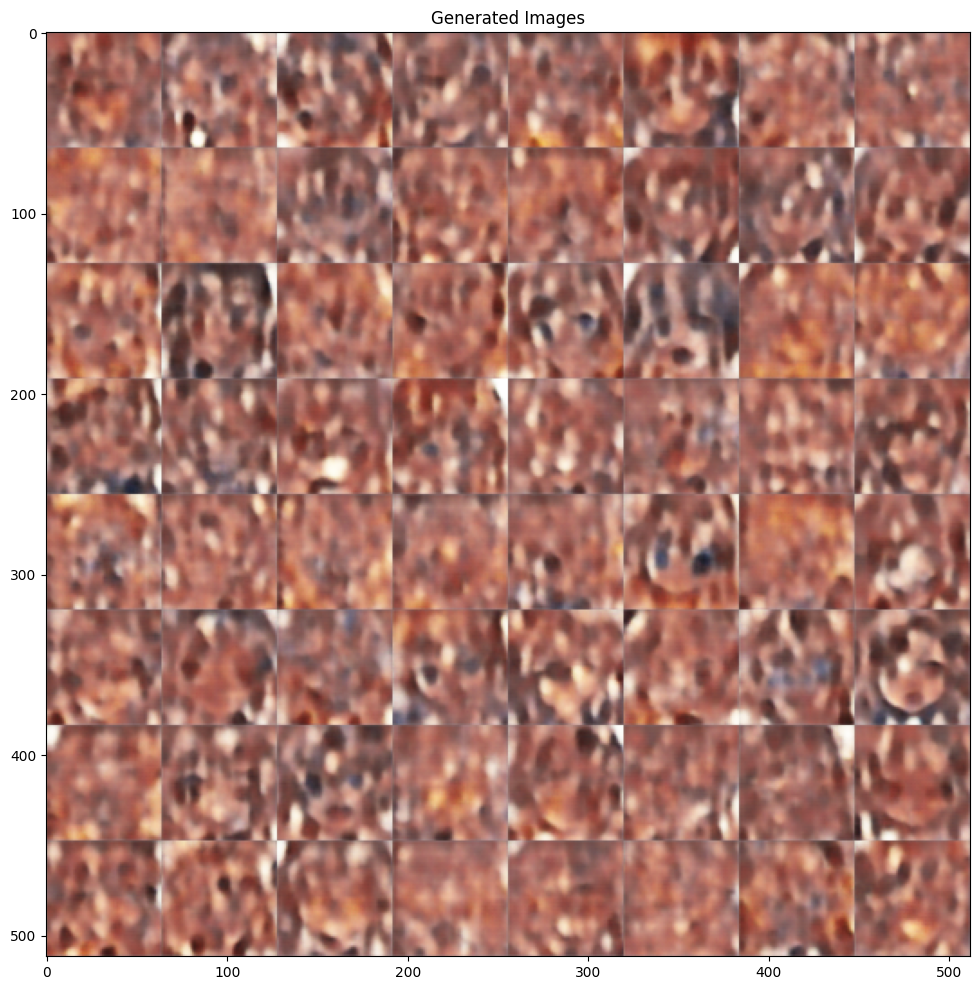

In [62]:

def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')